# Convolutional Neural Network
Spencer Hann
EE 584 - Final Project

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from cnn.data import preprocess_data

In [2]:
training_examples, training_targets = \
    preprocess_data("data/mnist_train.csv", max_rows=20000)
validation_examples, validation_targets = \
    preprocess_data("data/mnist_test.csv", max_rows=200)

data = (training_examples, training_targets, validation_examples, validation_targets)
train_set = (training_examples, training_targets)
val_set = (validation_examples, validation_targets)

loading data/mnist_train.csv... done. (20000, 785)
loading data/mnist_test.csv... done. (100, 785)


## Proof of Concept: Simple Neural Net Layer


This section demonstrates, in a very simplified way, my approach to the problem of creating interconnectable, modular neural network layers.

In [3]:
from cnn.cnn import CNN, Layer, DenseSoftmaxLayer, ConvolutionalLayer

In [4]:
class DenseLayer(Layer):
    def __init__(self, insize, outsize=10):
        # layer dimensions
        self.insize = insize
        self.outsize = outsize

        # random weight initializations
        self.w = np.random.randn(insize, outsize) / insize
        self.b = np.random.randn(outsize) / outsize

    def forward(self, image):
        image = image.flatten()  # dense layer requires a flat vector

        # fully-connected/matmul phase + bias
        result = np.dot(image, self.w) + self.b
        return result

A simple nerual net fully connected layer that simply takes its input and multiplies it by its weight matrix.

In [5]:
# create example layers
layer1 = DenseLayer(28*28, 64)
layer2 = DenseLayer(64, 10)

Create multiple layers with matching `outsize` and `insize` dimensions.

In [6]:
def forward(image, label):
    middle = layer1.forward(image)
    out = layer2.forward(middle)
    
    is_correct = np.argmax(out) == label
    return None, is_correct

Any number of `Layer` objects can be strung together so that each successive layer receives the outputs of the previous.

In [7]:
def test(images, labels):
    n_correct = 0.0
    for image, label in zip(images, labels):
        _, c = forward(image, label)
        n_correct += c
    return n_correct / len(images)

In [8]:
accuracy = 100 * test(*val_set)  # should be about 1 / n_classes
print(f"Accuracy: {round(accuracy)}%")

Accuracy: 14.0%


This is a randomly initialized network that we will test the feed forward functionality on.  With 10 evenly represented output classes in our testing data, we expect to see roughly 10% accuracy.

## Adding Back Propagation

In [9]:
class DenseLayer(Layer):
    def __init__(self, insize, outsize=10):
        self.insize = insize
        self.outsize = outsize

        self.w = np.random.randn(insize, outsize) / insize
        self.b = np.random.randn(outsize) / outsize

    def forward(self, image):
        self.last_image = image        # <<----
        image = image.flatten()

        # fully-connected/matmul phase
        fc = np.dot(image, self.w) + self.b
        self.last_fc = fc              # <<----

        return fc

    def backprop(self, loss_grad, lr):
        # output gradients wrt input, biases, weights
        ograd_input = self.w
        ograd_biases = 1
        ograd_weights = self.last_image.flatten()

        # loss gradients wrt input, biases, weights
        lgrad_input = ograd_input @ loss_grad
        lgrad_biases = ograd_biases * loss_grad
        lgrad_weights = ograd_weights[:,np.newaxis] @ loss_grad[np.newaxis]

        # update layer
        self.w += lr * lgrad_weights
        self.b += lr * lgrad_biases
        return lgrad_input.reshape(self.last_image.shape)

In [10]:
from cnn.cnn import ReLULayer
cnn = CNN((
    ConvolutionalLayer(1,4,3),
    DenseLayer(28*28*4, 64),
    ReLULayer(),
    DenseSoftmaxLayer(64,10)
), lr=0.008, lr_decay=0.9)
cnn

<CNN: lr=0.008, lr_decay=0.9, 
layers=(	
<ConvolutionalLayer: (1, 4, 3), momentum=0.0>,	
<DenseLayer>,	
<ReLULayer>,	
<DenseSoftmaxLayer: (64, 10)>
)>

I wrap this example `DenseLayer` in a `CNN` object with some other layers. The CNN object allows thes packages

In [11]:
%time cnn.train_test_cycle(5, 1, train_set, val_set, sample_size=400)

Training 0/1...
Epoch 0/5: 2.31 loss, 11.00% accurate, lr=0.008, 
Epoch 1/5: 2.31 loss, 19.75% accurate, lr=0.007200000000000001, 
Epoch 2/5: 2.31 loss, 21.00% accurate, lr=0.0064800000000000005, 
Epoch 3/5: 2.31 loss, 18.25% accurate, lr=0.005832, 
Epoch 4/5: 2.30 loss, 20.50% accurate, lr=0.0052488000000000005, 
Testing 0/1...
Test: 2.30 loss, 18.00% accurate
CPU times: user 6min 25s, sys: 4min 12s, total: 10min 38s
Wall time: 2min 49s


# Demonstration of Full Networks

The layers I built can be stacked in multiple ways to make arbitrary convolutional and fully-connected nerual architectures and trained. Each contains a `forward` function, and `backprop` function that lets them communicate loss gradients to each other during gradient descent.

In [12]:
from cnn.cnn import (
    CNN, 
    ConvolutionalLayer, 
    MaxPoolingLayer, 
    DenseSoftmaxLayer,
    ReLULayer,
)

In [13]:
cnn = CNN((
    ConvolutionalLayer(1,3,3),
    MaxPoolingLayer(2),
    ConvolutionalLayer(3,1,3),
    ReLULayer(),
    DenseSoftmaxLayer(14*14, 10),
))
cnn

<CNN: lr=0.01, lr_decay=0.9, 
layers=(	
<ConvolutionalLayer: (1, 3, 3), momentum=0.0>,	
<MaxPoolingLayer: 2>,	
<ConvolutionalLayer: (3, 1, 3), momentum=0.0>,	
<ReLULayer>,	
<DenseSoftmaxLayer: (196, 10)>
)>

In my `cnn.ConvolutionalLayer` class, the arguments are `(n_channels, n_filters, filter_size)`, currently only square filters are supported.

In [14]:
cnn.test(*val_set);

Test: 2.31 loss, 7.00% accurate


Approximately random perfomance is to be expected.  This shows that feed forward is working properly, but that no learning has occured yet.

## Demonstration of Back Propogation

This section demonstrates support for multiple different neural architectures.

In [15]:
from matplotlib import pyplot as plt

In [16]:
def_sample_size = 2000;

In [17]:
def veiw_filters(cnn, layer = 0):  # only for filters w/ depth = 1 (first layer)
    """graphical view of what convolutional filters the network is learning."""
    plt.cla()
    n = len(cnn.layers[layer].filters)
    for i, fltr in enumerate(cnn.layers[layer].filters):
        plt.subplot(1, n+1, i+1)
        fltr -= fltr.min()
        fltr /= fltr.max()
        plt.imshow(fltr[0], cmap="gray")
        plt.xticks(()); plt.yticks(());
    plt.show()

In [18]:
cnn = CNN((
    ConvolutionalLayer(1,8,3),
    DenseSoftmaxLayer(28*28*8, 10),
))
cnn

<CNN: lr=0.01, lr_decay=0.9, 
layers=(	
<ConvolutionalLayer: (1, 8, 3), momentum=0.0>,	
<DenseSoftmaxLayer: (6272, 10)>
)>

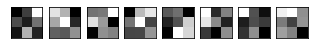

In [19]:
veiw_filters(cnn)

In [20]:
%time cnn.train_test_cycle(3, 2, train_set, val_set, sample_size=def_sample_size)

Training 0/2...
Epoch 0/3: 2.12 loss, 49.30% accurate, lr=0.01, 
Epoch 1/3: 1.55 loss, 62.15% accurate, lr=0.009000000000000001, 
Epoch 2/3: 1.58 loss, 62.60% accurate, lr=0.008100000000000001, 
Testing 0/2...
Test: 1.50 loss, 64.00% accurate
Training 1/2...
Epoch 0/3: 1.64 loss, 61.75% accurate, lr=0.007290000000000001, 
Epoch 1/3: 1.60 loss, 62.05% accurate, lr=0.006561000000000002, 
Epoch 2/3: 1.61 loss, 63.05% accurate, lr=0.005904900000000002, 
Testing 1/2...
Test: 1.46 loss, 67.00% accurate
CPU times: user 41min 39s, sys: 26min 35s, total: 1h 8min 15s
Wall time: 19min 43s


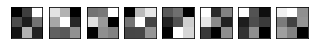

In [21]:
veiw_filters(cnn)

In [22]:
cnn = CNN((
    ConvolutionalLayer(1,3,3),
    MaxPoolingLayer(2),
    ConvolutionalLayer(3,3,3),
    DenseSoftmaxLayer(14*14*3, 10),
))
cnn

<CNN: lr=0.01, lr_decay=0.9, 
layers=(	
<ConvolutionalLayer: (1, 3, 3), momentum=0.0>,	
<MaxPoolingLayer: 2>,	
<ConvolutionalLayer: (3, 3, 3), momentum=0.0>,	
<DenseSoftmaxLayer: (588, 10)>
)>

In [23]:
%time cnn.train_test_cycle(3, 2, train_set, val_set, sample_size=def_sample_size)

Training 0/2...
Epoch 0/3: 2.31 loss, 10.75% accurate, lr=0.01, 
Epoch 1/3: 2.26 loss, 47.55% accurate, lr=0.009000000000000001, 
Epoch 2/3: 2.18 loss, 68.45% accurate, lr=0.008100000000000001, 
Testing 0/2...
Test: 2.12 loss, 71.00% accurate
Training 1/2...
Epoch 0/3: 2.04 loss, 72.90% accurate, lr=0.007290000000000001, 
Epoch 1/3: 1.89 loss, 72.60% accurate, lr=0.006561000000000002, 
Epoch 2/3: 1.76 loss, 74.55% accurate, lr=0.005904900000000002, 
Testing 1/2...
Test: 1.74 loss, 76.00% accurate
CPU times: user 5min 18s, sys: 120 ms, total: 5min 18s
Wall time: 5min 18s


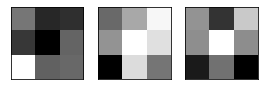

In [24]:
veiw_filters(cnn)

In [25]:
cnn = CNN((
    ConvolutionalLayer(1,8,3),
    ConvolutionalLayer(8,4,3),
    DenseSoftmaxLayer(28*28*4, 10),
))
cnn

<CNN: lr=0.01, lr_decay=0.9, 
layers=(	
<ConvolutionalLayer: (1, 8, 3), momentum=0.0>,	
<ConvolutionalLayer: (8, 4, 3), momentum=0.0>,	
<DenseSoftmaxLayer: (3136, 10)>
)>

In [26]:
%time cnn.train_test_cycle(3, 2, train_set, val_set, sample_size=def_sample_size)

Training 0/2...
Epoch 0/3: 1.92 loss, 45.45% accurate, lr=0.01, 
Epoch 1/3: 1.37 loss, 67.55% accurate, lr=0.009000000000000001, 
Epoch 2/3: 1.35 loss, 71.55% accurate, lr=0.008100000000000001, 
Testing 0/2...
Test: 1.34 loss, 73.00% accurate
Training 1/2...
Epoch 0/3: 1.40 loss, 68.40% accurate, lr=0.007290000000000001, 
Epoch 1/3: 1.43 loss, 68.55% accurate, lr=0.006561000000000002, 
Epoch 2/3: 1.44 loss, 69.05% accurate, lr=0.005904900000000002, 
Testing 1/2...
Test: 1.41 loss, 68.00% accurate
CPU times: user 50min 45s, sys: 29min 57s, total: 1h 20min 43s
Wall time: 25min 43s


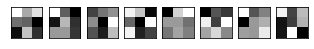

In [27]:
veiw_filters(cnn)

In [31]:
cnn = CNN(
    (
        ConvolutionalLayer(1,16,3),
        MaxPoolingLayer(2),
        ReLULayer(),
        ConvolutionalLayer(16,32,3),
        MaxPoolingLayer(2),
        ReLULayer(),
        DenseSoftmaxLayer(7*7*32, 10),
    ), 
    lr = 0.01,
    lr_decay = 0.8,
)
cnn

<CNN: lr=0.01, lr_decay=0.8, 
layers=(	
<ConvolutionalLayer: (1, 16, 3), momentum=0.0>,	
<MaxPoolingLayer: 2>,	
<ReLULayer>,	
<ConvolutionalLayer: (16, 32, 3), momentum=0.0>,	
<MaxPoolingLayer: 2>,	
<ReLULayer>,	
<DenseSoftmaxLayer: (1568, 10)>
)>

In [32]:
%time cnn.train_test_cycle(3, 3, train_set, val_set, sample_size=3000)

Training 0/3...
Epoch 0/3: 2.30 loss, 19.67% accurate, lr=0.01, 
Epoch 1/3: 2.30 loss, 48.80% accurate, lr=0.008, 
Epoch 2/3: 2.30 loss, 63.73% accurate, lr=0.0064, 
Testing 0/3...
Test: 2.30 loss, 67.00% accurate
Training 1/3...
Epoch 0/3: 2.30 loss, 67.67% accurate, lr=0.00512, 
Epoch 1/3: 2.30 loss, 72.07% accurate, lr=0.004096000000000001, 
Epoch 2/3: 2.30 loss, 74.37% accurate, lr=0.0032768000000000007, 
Testing 1/3...
Test: 2.30 loss, 78.00% accurate
Training 2/3...
Epoch 0/3: 2.30 loss, 74.70% accurate, lr=0.002621440000000001, 
Epoch 1/3: 2.30 loss, 76.67% accurate, lr=0.002097152000000001, 
Epoch 2/3: 2.30 loss, 77.10% accurate, lr=0.001677721600000001, 
Testing 2/3...
Test: 2.30 loss, 77.00% accurate
CPU times: user 2h 32min 22s, sys: 1h 3min 34s, total: 3h 35min 57s
Wall time: 1h 39min 21s


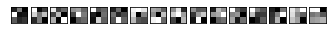

In [33]:
veiw_filters(cnn)